In [6]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [12]:
data = pd.read_csv("requests.csv")

In [13]:
data.head(2)

,question,target
0,До каква сума може да изтегли клиент на каса б...,АТМ И КАСОВА ДЕЙНОСТ
1,дай ми линк към искане за оспорване,БАНКОВИ ОПЕРАЦИИ


In [14]:
data["target"] = data["target"].str.strip()

In [15]:
data["target"].value_counts()

target
Ежедневно банкиране                   154
Други                                  71
Жилищни и ипотечни кредити             59
Потребителско кредитиране              38
Разсрочени плащания                    34
БАНКОВИ ОПЕРАЦИИ                       28
Малък бизнес                           27
Спестяване и инвестиции                20
Няколко                                17
Банково застраховане                   16
АТМ И КАСОВА ДЕЙНОСТ                   15
КРЕДИТЕН РИСК ИНДИВИДУАЛНИ КЛИЕНТИ     12
ПРАВНО                                  5
CRM                                     3
Name: count, dtype: int64

In [16]:
data.shape

(499, 2)

## Experiment with prototype-based classification

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sentence_transformers import SentenceTransformer
import numpy as np

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data['question'], data['target'], test_size=0.2, random_state=42)


train_data = pd.DataFrame({'question': X_train, 'target': y_train})
test_data = pd.DataFrame({'question': X_test, 'target': y_test})


### Get embeding that has semantic meaning of questions

In [18]:
model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')
train_data['embedding'] = train_data['question'].apply(lambda x: model.encode(x))
test_data['embedding'] = test_data['question'].apply(lambda x: model.encode(x))


In [19]:
train_data.head(3)

,question,target,embedding
56,тип 12 е самоосигуряващ се в регистрите на НОИ,Други,"[-0.08052378, 0.119733, -0.015745325, 0.077093..."
227,Каква е ползата от използването на кредитна ка...,Разсрочени плащания,"[-0.019389706, 0.0035240434, -0.007871629, 0.0..."
280,къде са качени офертите за сегмент младежи ?,Други,"[0.04155403, 0.1087602, -0.011502612, -0.11365..."


In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

In [22]:
le = LabelEncoder()

le.fit(train_data["target"])
train_data["target_encoded"] = le.transform(train_data["target"])
test_data["target_encoded"] = le.transform(test_data["target"])


In [23]:
neigh = KNeighborsClassifier(n_neighbors=5)

X = np.vstack(train_data["embedding"].values)
y = train_data["target_encoded"].values

neigh.fit(X, y)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [24]:
X_test = np.vstack(test_data["embedding"].values)
test_data["prediction_encoded"] = neigh.predict(X_test)
test_data["prediction"] = le.inverse_transform(test_data["prediction_encoded"])

### Create category prototypes from training data

### Evaluate results

In [25]:
accuracy = accuracy_score(test_data['target'], test_data["prediction"])
report = classification_report(test_data['target'], test_data["prediction"])

print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)

Accuracy: 0.4700

Classification Report:
                                    precision    recall  f1-score   support

              АТМ И КАСОВА ДЕЙНОСТ       0.40      0.50      0.44         4
                  БАНКОВИ ОПЕРАЦИИ       0.18      0.60      0.27         5
              Банково застраховане       0.33      1.00      0.50         1
                             Други       0.42      0.42      0.42        12
               Ежедневно банкиране       0.48      0.62      0.54        26
        Жилищни и ипотечни кредити       0.91      0.62      0.74        16
КРЕДИТЕН РИСК ИНДИВИДУАЛНИ КЛИЕНТИ       0.00      0.00      0.00         2
                      Малък бизнес       0.40      0.50      0.44         4
                           Няколко       0.00      0.00      0.00         3
                            ПРАВНО       0.00      0.00      0.00         4
         Потребителско кредитиране       0.43      0.43      0.43         7
               Разсрочени плащания       0.67 

/home/hp/Downloads/takehome_categorizer/dsk/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hp/Downloads/takehome_categorizer/dsk/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hp/Downloads/takehome_categorizer/dsk/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

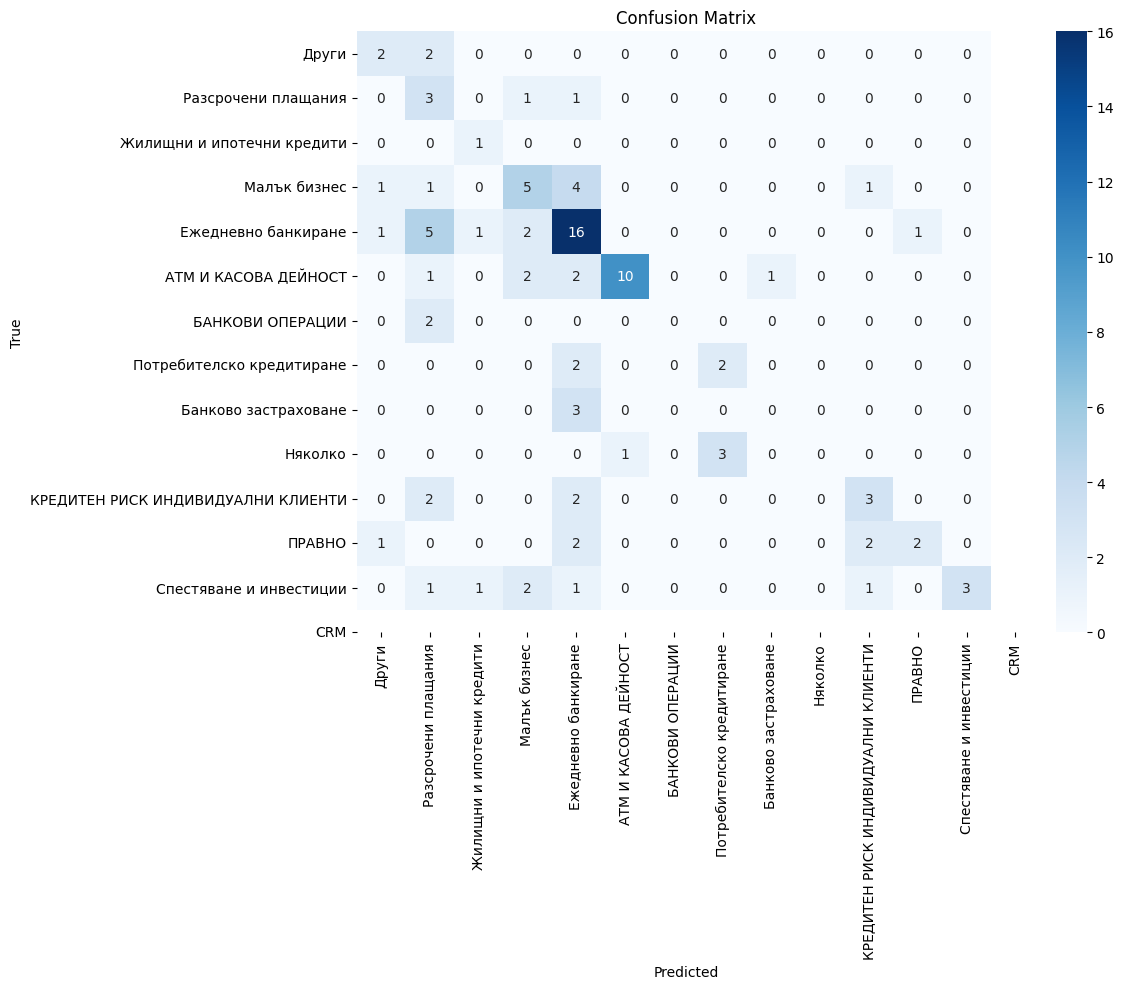

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(test_data['target'], test_data["prediction"])

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_data['target'].unique(),
            yticklabels=train_data['target'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## For saving artifacts

In [27]:
import joblib

import numpy as np
import os

# Create directories if they don't exist
os.makedirs('text_classifier/model_files', exist_ok=True)

# Bundle all artifacts
artifacts = {
    "model_name": "paraphrase-multilingual-mpnet-base-v2",
    "label_encoder": le,
    "knn": neigh
}

# Save all artifacts to one file
joblib.dump(artifacts, "text_classifier/model_files/artifacts.joblib")


print("Model artifacts saved successfully to model_files/")

Model artifacts saved successfully to model_files/


### Loading artifacts and making predicitons

In [28]:

# Load artifacts
artifacts = joblib.load("text_classifier/model_files/artifacts.joblib")
model = SentenceTransformer(artifacts["model_name"])
knn = artifacts["knn"]
le = artifacts["label_encoder"]


def forecast_class(text):    
    embedding = model.encode(text)

    embedding = np.array(embedding).reshape(1, -1)
    pred_encoded = knn.predict(embedding)
    pred_label = le.inverse_transform(pred_encoded)
    return pred_label[0]

forecast_class("Искам кредит")

'Жилищни и ипотечни кредити'